In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix,
    mean_squared_error
)
from xgboost import XGBRegressor
import optuna

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data (Tram)
data = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/STOR665/2025_NBA_Project/nba_playoffdata_combined.csv")
data.shape

(656, 56)

In [3]:
# Save team name columns
winners = data['Winner'].copy()
losers = data['Loser'].copy()

# Create target: Net Win Differential
def compute_net_wins(row):
    if row['Winner Seed'] < row['Loser Seed']:  # Winner is higher seed
        return row['Winner Games Won'] - row['Loser Games Won']
    else:  # Loser is higher seed
        return row['Loser Games Won'] - row['Winner Games Won']

data['Net Wins'] = data.apply(compute_net_wins, axis=1)

# Drop columns that directly make target dependent
data.drop(columns=['Winner', 'Loser', 'Winner Team', 'Loser Team', 
                   'Winner Games Won', 'Loser Games Won'], inplace=True)

# Create dummy variables for categorical
data = pd.get_dummies(data, drop_first=True)

# Check data
data.head()

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser TOV,Loser PF,Loser PTS,Net Wins,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2024,1,8,2,241.8,43.9,90.2,0.487,16.5,42.5,...,12.7,17.3,110.1,3,True,False,False,False,False,False
1,2024,4,5,20,241.5,41.8,87.2,0.479,13.5,36.8,...,14.7,19.7,110.5,1,True,False,False,False,False,False
2,2024,6,3,1,240.3,47.0,92.7,0.507,13.2,35.3,...,12.9,19.2,119.0,-2,True,False,False,False,False,False
3,2024,2,7,19,240.6,41.3,88.7,0.465,13.2,35.8,...,12.0,20.3,114.6,2,True,False,False,False,False,False
4,2024,1,8,3,241.5,44.5,89.3,0.499,13.3,34.2,...,13.0,18.4,115.1,4,False,False,False,False,True,False


In [4]:
# XGBoost
# Train/test split
X = data.drop('Net Wins', axis=1)
y = data['Net Wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)

# Define Optuna Objective Function 
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 665,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# Run Optuna Study 
study = optuna.create_study(direction="minimize") # lower MSE is better -> want to minimize MSE
study.optimize(objective, n_trials=25)  

# Best hyperparameters
print("Best hyperparameters found:", study.best_params)

# Retrain final model 
best_params = study.best_params
best_params["random_state"] = 665
best_params["n_jobs"] = -1

xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# XGBoost prediction
xgb_preds = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
print(f"XGBoost Test MSE after tuning: {xgb_mse:.4f}")

[I 2025-04-25 14:38:36,566] A new study created in memory with name: no-name-40b08b3b-1ecd-410e-9c3f-4c3ec19bd6c1
[I 2025-04-25 14:38:37,781] Trial 0 finished with value: 1.3202566819173243 and parameters: {'n_estimators': 850, 'max_depth': 8, 'learning_rate': 0.20710054832821015, 'subsample': 0.8136196171084471, 'colsample_bytree': 0.9309280558333871, 'gamma': 2.034388224239276, 'reg_alpha': 2.3388278974490913, 'reg_lambda': 3.7639381087302146}. Best is trial 0 with value: 1.3202566819173243.
[I 2025-04-25 14:38:41,955] Trial 1 finished with value: 1.1992538636029328 and parameters: {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.017674810962913252, 'subsample': 0.6386671071446255, 'colsample_bytree': 0.9730796124566714, 'gamma': 0.746583708799427, 'reg_alpha': 2.8646976103227946, 'reg_lambda': 0.03020602722024701}. Best is trial 1 with value: 1.1992538636029328.
[I 2025-04-25 14:38:43,695] Trial 2 finished with value: 1.7212132280263062 and parameters: {'n_estimators': 1000,

[I 2025-04-25 14:39:13,702] Trial 21 finished with value: 1.1930522459045325 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.010971887392290712, 'subsample': 0.7244015452322764, 'colsample_bytree': 0.7768720149651341, 'gamma': 3.782440839908585, 'reg_alpha': 1.3165751182153453, 'reg_lambda': 2.2998241637566372}. Best is trial 14 with value: 1.164738592051237.
[I 2025-04-25 14:39:14,890] Trial 22 finished with value: 1.152988325811254 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.013608872664577009, 'subsample': 0.6404152344704105, 'colsample_bytree': 0.8409046498671504, 'gamma': 4.395503055846766, 'reg_alpha': 0.038085093393348285, 'reg_lambda': 3.0018328361963054}. Best is trial 22 with value: 1.152988325811254.
[I 2025-04-25 14:39:15,915] Trial 23 finished with value: 1.149103055115314 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.013717656285682197, 'subsample': 0.629448390676192, 'colsample_bytree': 0.8

Best hyperparameters found: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.014459459822438835, 'subsample': 0.6267537497195592, 'colsample_bytree': 0.9903773183723106, 'gamma': 4.4705936775706485, 'reg_alpha': 0.3610939379021536, 'reg_lambda': 3.1613862484636774}
XGBoost Test MSE after tuning: 1.1086


/var/folders/4k/hzdv3gfx38s7_yqt0z_6kjyr0000gp/T/ipykernel_68758/248682778.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


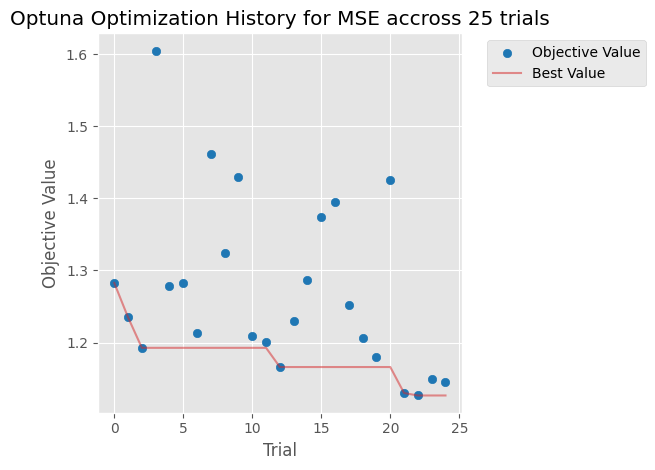

In [9]:
# Plot how MSE changed across 25 trials
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History for MSE accross 25 trials")
plt.tight_layout()
plt.show()

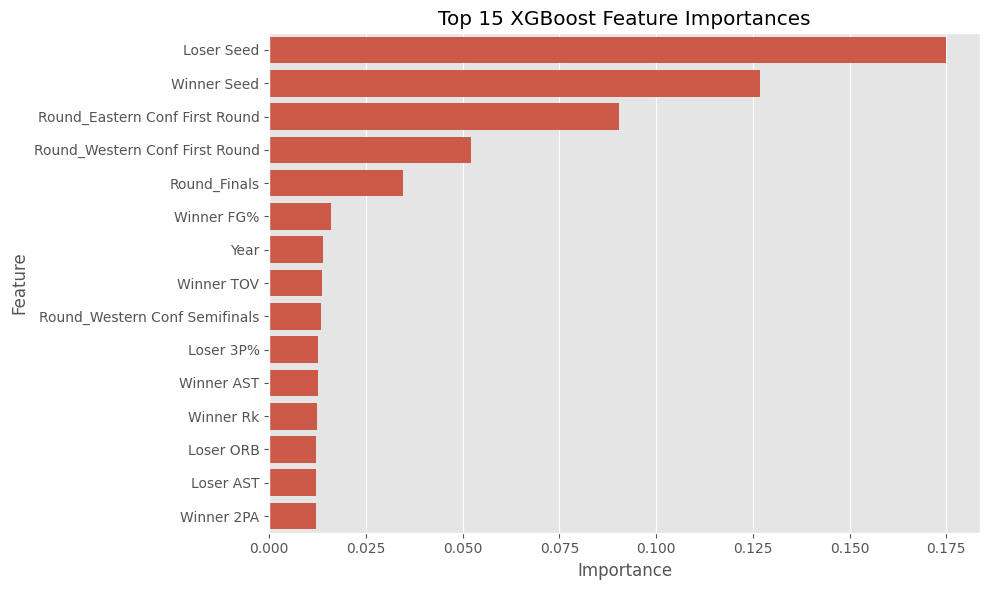

In [10]:
# Plot feature importance from XGBoost model
# Get feature importances
importances = xgb_model.feature_importances_
features = X.columns

# Combine and sort
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15))
plt.title('Top 15 XGBoost Feature Importances')
plt.tight_layout()
plt.show()